# 1. Исследовательский анализ данных

### Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 
### Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.


### Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

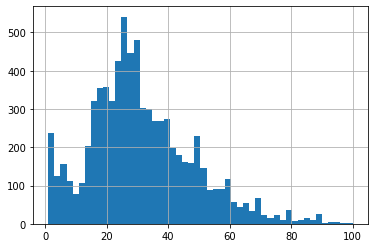

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

labels['real_age'].hist(bins=50);

In [3]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

**Несмотря на то что среднее больше медианы на 2 года, распределение не имеет признак нормального - есть сдвиг вправо, например, есть около 150 фото с возрастом в 1 год и 50 лет, которые выбиваются в нашем распределении**

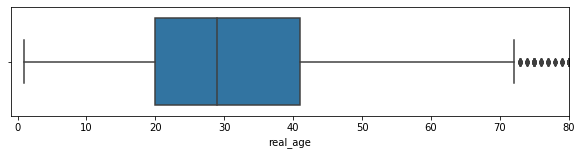

In [4]:
fig, axes = plt.subplots(figsize=(10, 2))
axes.set_xlim(-1,80)
sns.boxplot(x=labels['real_age'], data = labels,
            orient="h", ax = axes);

In [5]:
labels['real_age'].value_counts()[:5]

30    317
25    315
27    229
26    226
28    217
Name: real_age, dtype: int64

**Саммый распространенный возраст в наших данных 25-30 лет**

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        seed=12345)

features, target = next(train_gen_flow)

Found 7591 validated image filenames.


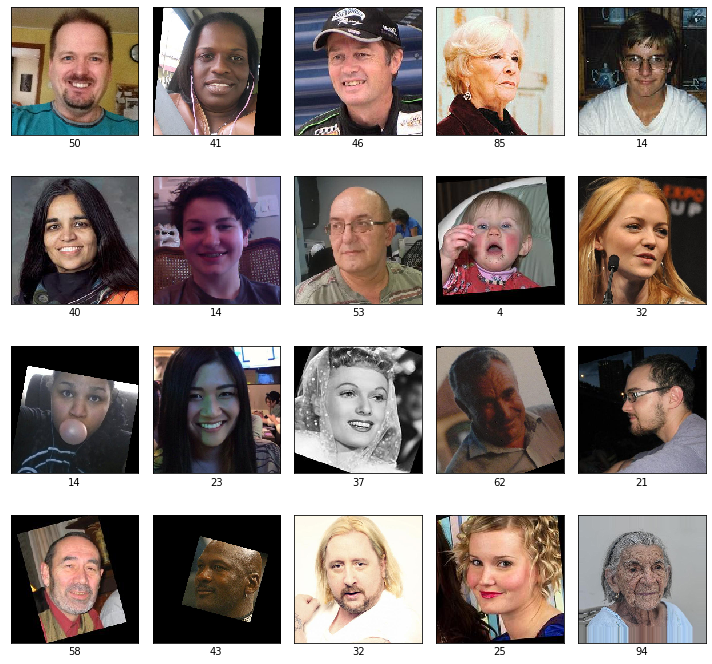

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(20):
    fig.add_subplot(4, 5, i+1)
    plt.imshow(features[i])
    plt.xlabel(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Судя по фото разметка данных достаточно корректна 

**По фото в наборе, можно сделать следующие выводы:**
1. Практически на всех фото изображено лицо одного человека
2. Зачастую лицо занимает большую часть фото
3. Есть лица, расположенные как анфас, так и в профиль
4. Некоторые фото обрамлены рамками различной ширины
5. Фото сделаны с разным уровнем освещенностии и цветности

**Думаю, что могут улучшить показатели модели поворот по горизонтали (так как профили повернуты и вправо и влево, а для анфас это ухудшит результат), изменение яркости и контрастности (фото сделаны в разных условиях), размытие и повышение чёткости (фото сделаны в разное время, на аппараты разного качества съемки). Эффекты следует применять по одному только к обучающей выборке, а результат оценивать на тесте.**

In [8]:
labels.shape

(7591, 2)

**Данных в датасете мало, этого объема не хватит для эффективного обучения, модели необходимы дополнительные данные, но каждый раз обучать модель на больших объемах данных долго и не эффективно, проще и быстрее для последующего дообучения взять готовую модель, обученную на изображениях**

# 2. Обучение модели


**Данных мало. Чтобы не было эффекта переобучения лучше использовать предобученную модель и дообучать ее на нашем датасете, также применено добавление шума в данные - случайные фото в датасете будут развернуты по горизонтали. Тренировочная и тестовая выборки разбиты в соотношении 75 на 25 процентов. Взята предобученная на данных imagenet модель ResNet50 без верхушки. Добавлен пулинг средним значением по всему изображению и полносвязный слой из одного нейрона с активацией ReLu (так как у нас задача регрессии). В качестве алгоритма обучения воспользуемся алгоритмом Adam - будет автоматически подбирать шаг обучения, начиная с 0.0005. Для быстроты обучения возьмем функцию потерь mse, целевая метрика mae. Кол-во эпох экспериментально возьмем равным 20**

```python

# < 
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,horizontal_flip=True,rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model >

```

```
Epoch 1/20
356/356 - 112s - loss: 202.6979 - mae: 10.8415 - val_loss: 306.8048 - val_mae: 13.0109
Epoch 2/20
356/356 - 41s - loss: 136.8791 - mae: 9.0053 - val_loss: 185.9926 - val_mae: 10.4330
Epoch 3/20
356/356 - 41s - loss: 112.1790 - mae: 8.0539 - val_loss: 113.5005 - val_mae: 7.9143
Epoch 4/20
356/356 - 41s - loss: 97.5594 - mae: 7.5181 - val_loss: 122.4999 - val_mae: 8.5065
Epoch 5/20
356/356 - 41s - loss: 82.3384 - mae: 6.8830 - val_loss: 116.5444 - val_mae: 8.2107
Epoch 6/20
356/356 - 41s - loss: 69.0822 - mae: 6.3757 - val_loss: 95.4347 - val_mae: 7.4531
Epoch 7/20
356/356 - 41s - loss: 63.7855 - mae: 6.1589 - val_loss: 107.1984 - val_mae: 7.8427
Epoch 8/20
356/356 - 41s - loss: 50.7879 - mae: 5.5069 - val_loss: 116.6608 - val_mae: 8.0309
Epoch 9/20
356/356 - 41s - loss: 42.2247 - mae: 5.0351 - val_loss: 138.1807 - val_mae: 8.6790
Epoch 10/20
356/356 - 41s - loss: 38.8135 - mae: 4.7597 - val_loss: 97.7636 - val_mae: 7.3754
Epoch 11/20
356/356 - 41s - loss: 32.6105 - mae: 4.4203 - val_loss: 97.3496 - val_mae: 7.4350
Epoch 12/20
356/356 - 41s - loss: 25.9516 - mae: 3.9735 - val_loss: 82.8011 - val_mae: 6.7541
Epoch 13/20
356/356 - 40s - loss: 29.2553 - mae: 4.1620 - val_loss: 121.5402 - val_mae: 8.2628
Epoch 14/20
356/356 - 41s - loss: 26.3863 - mae: 3.9890 - val_loss: 127.1557 - val_mae: 7.9564
Epoch 15/20
356/356 - 41s - loss: 20.8830 - mae: 3.5406 - val_loss: 90.5105 - val_mae: 7.1837
Epoch 16/20
356/356 - 41s - loss: 21.1232 - mae: 3.5397 - val_loss: 87.1600 - val_mae: 6.9167
Epoch 17/20
356/356 - 41s - loss: 18.3564 - mae: 3.3045 - val_loss: 84.3390 - val_mae: 6.8449
Epoch 18/20
356/356 - 41s - loss: 17.7788 - mae: 3.2473 - val_loss: 101.8871 - val_mae: 7.6420
Epoch 19/20
356/356 - 41s - loss: 20.1252 - mae: 3.4513 - val_loss: 172.9436 - val_mae: 9.6864
Epoch 20/20
356/356 - 41s - loss: 18.2797 - mae: 3.2514 - val_loss: 92.7722 - val_mae: 7.1936

119/119 - 10s - loss: 92.7722 - mae: 7.1936
Test MAE: 7.1936 >
```

# 3. Анализ обученной модели

***После 12 эпох наблюдается процесс переобучения, в итоге именно на 12 эпохе модель показывает лучшую метрику на тестовой выборке (предполагаю модель хорошо выучивается на фото с людьми в возрастном диапазоне 15-40 лет, данных с ними больше). Думаю, что для оценки возраста при  продаже алкоголя наша модель покажет себя лучше (фото с людьми 18 лет больше), чем для рекомендации товаров для определенной возрастной группы (распределение не достаточно равномерно и вообще данных мало).***

# Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы